# This notebook plots numerical solutions and computes/plots analytic solutions for the default parameter set-up throughout the paper.

Here, we create figures: 3,4,5 in the main text and all appendix figures (A1, B1, B2)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import copy
from matplotlib import rcParams
import seaborn as sns
sns.set_style("whitegrid")

In [35]:
L_x_h =3795751.714012305 #zonal width of domain, h variable
L_y_h = 13785809.584401697 #meridional width of domain, h variable
nx = 128 #number grid points, zonal
ny = 129 #number grid points, meridional

L_x =(ny/(ny-1))*L_x_h 
L_y = (nx/(nx-1))*L_y_h

dx = L_x / nx #grid spacing, zonal
dy = L_y / ny #grid spacing, meridional

H1=250 #layer thickness 1
H2=250 #layer thickness 2

#Set coriolis values
omega=7.2921E-5
ref_lat=0
f0=2*omega*np.sin(np.deg2rad(ref_lat))
beta=2*omega*np.cos(np.deg2rad(ref_lat))/(6.637E6)

# Set densities and reduced gravity
rho0 = 1024.0 #reference density of fluid
rho3=1030 #density abyssal fluid
rho2=1028 #density bottom active layer
rho1=1026 #density top active layer

g1= 9.8*(rho2-rho1)/rho1 #reduced gravity 1
g2= 9.8*(rho3-rho2)/rho1 #reduced gravity 2

# positions of the u,v,h points
ux = (-L_x/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-L_x/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-L_y/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-L_y/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

hx = vx
hy = uy

#inverse f
f_v_inv=1/(f0 + beta*vy)


# 1. Load in numerical results. In the next section, we will do analytics. 

In [36]:
#These have to be created using the execute files in the subfodler 250m_rhodiff2
#For ease of being able to run this main notebook without running the execute files, we have made these available on google drive:
#https://drive.google.com/drive/folders/1Z1Tk683nuRAuMG4KPhCP8TACMFuEWxJC?usp=sharing

# Load in top perturbation
h2=xr.open_dataset("./output_files/h2_xr_control_years0to75_toplayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h2_xr_top=(h2.to_array()).squeeze()

h1=xr.open_dataset("./output_files/h1_xr_control_years0to75_toplayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h1_xr_top=(h1.to_array()).squeeze()



# Load in bottom perturbation
h2=xr.open_dataset("./output_files/h2_xr_control_years0to75_bottomlayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h2_xr_bottom=(h2.to_array()).squeeze()

h1=xr.open_dataset("./output_files/h1_xr_control_years0to75_bottomlayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h1_xr_bottom=(h1.to_array()).squeeze()

In [37]:
# Compare h1/h2 in each experiment for the approximation needed at the southern edge of the domain
a=np.mean(np.abs(h1_xr_bottom[30,:,:]/h2_xr_bottom[30,:,:]-1))
b=np.mean(np.abs(h1_xr_top[30,:,:]/h2_xr_top[30,:,:]-1))
c=np.mean(np.abs(h2_xr_bottom[30,:,:]/h1_xr_bottom[30,:,:]-1))
d=np.mean(np.abs(h2_xr_top[30,:,:]/h1_xr_top[30,:,:]-1))
print((a+b+c+d)/4)


a=np.abs(h1_xr_bottom[30,:,:]/h2_xr_bottom[30,:,:]-1)
b=np.abs(h1_xr_top[30,:,:]/h2_xr_top[30,:,:]-1)
c=np.abs(h2_xr_bottom[30,:,:]/h1_xr_bottom[30,:,:]-1)
d=np.abs(h2_xr_top[30,:,:]/h1_xr_top[30,:,:]-1)
print(np.max([np.max(a),np.max(b),np.max(c),np.max(d)]))

<xarray.DataArray ()>
array(0.00542864)
Coordinates:
    y         float64 -3.662e+06
    variable  <U29 '__xarray_dataarray_variable__'
0.029953945650158298


# 2. Analytics to predict each layer thickness. Bottom layer perturbation

In [38]:
c1=np.zeros(np.size(h2_xr_top[:,10,10])-30)
for j in range(0,np.size(h2_xr_top[:,10,10])-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
wbc=12 #width of western boundary

#form a lag for each x point (other than wbc) throughout analytic domain
lag_l1_grid=np.zeros([129-30,128-wbc])
lag_l2_grid=np.zeros([129-30,128-wbc])

#creates an array for each point in analytic domain of the lag off the eastern boundary
for j in range(30,129):
    for i in range(wbc,128):
        lag_l1_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3+np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
        lag_l2_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3-np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
lag_l1_grid=lag_l1_grid.astype('int')
lag_l2_grid=lag_l2_grid.astype('int')

/state/partition1/job-55926434/ipykernel_401192/263420700.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


In [10]:
# predict eastern boundary height
c1=np.zeros(np.size(h1_xr_bottom[:,10,10])-ny//7-7-30) 
for j in range(0,np.size(h1_xr_bottom[:,10,10])-ny//7-7-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1]=1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

last_grid_pt=ny-ny//7-7


lag_l1=(((128-wbc)/128)*L_x/(((3+np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(((3-np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1

#Coefficients for the h_1 lag equation

b1_1=(5+np.sqrt(5))/10
b2_1=np.sqrt(5)/5
b3_1=(5-np.sqrt(5))/10
b4_1=-b2_1

#Coefficients for the h_2 lag equation
b1_2=1/np.sqrt(5)
b2_2=-(1-np.sqrt(5))/(2*np.sqrt(5))
b3_2=-1/np.sqrt(5)
b4_2=(1+np.sqrt(5))/(2*np.sqrt(5))


h1_east_est=H1*np.ones(4444)
h2_east_est=H1*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=H1*np.ones(np.size(c1))
    est_h2_bd=H1*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*H1+b4_1*H1
    #estimate western bdd of bottom layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*H1+b4_2*H1
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_bottom[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_bottom[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    #estimate of flux at southern boundary using only numerical information from wbc
    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_bottom[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_bottom[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])

    #estimate of flux at northern boundary using only numerical information from wbc
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

    #update h1 or h2 eastern boundary height
    h1_east_est[k]=((-dy*c1_cap*est_h1_bd).sum()-T_s1+T_s2+T_n1-T_n2)/(-c1_cap*dy).sum()
    h2_east_est[k]=((-dy*c1_cap*(est_h1_bd+est_h2_bd)).sum()-T_s2+T_n2+(h1_east_est[k]*c1_cap*dy).sum())/(-c1_cap*dy).sum()

/state/partition1/job-55926434/ipykernel_401192/4013605390.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


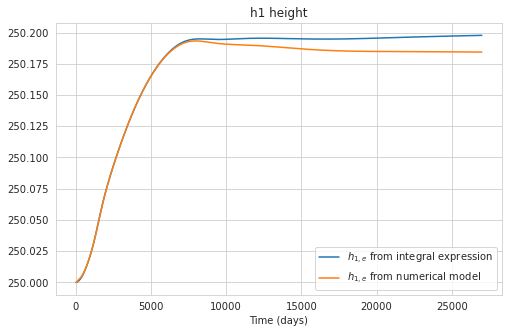

In [11]:
#Check our solution for eastern boundary height vs the true eastern boundary height

fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

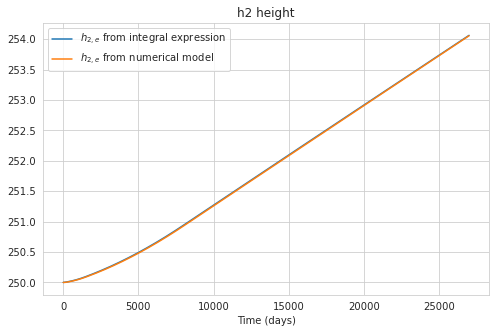

In [12]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h2_xr_bottom[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h2_xr_bottom[24:,127,:].time[0:4444],h2_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [13]:
#Predict the height throughout the basin using lag equation at the END TIME

pred_h1_bottompert_grid=np.zeros([129-30,128-wbc]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid=np.zeros([129-30,128-wbc]) #h2 height in the bottom perturbation experiment
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0: #if the time isn't more than the lag time off the eastern boundary, you need to use the initial condition where relevant
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1

#convert these all to xarrays
h1_pred_bottompert=xr.DataArray(pred_h1_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_bottompert=xr.DataArray(pred_h2_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

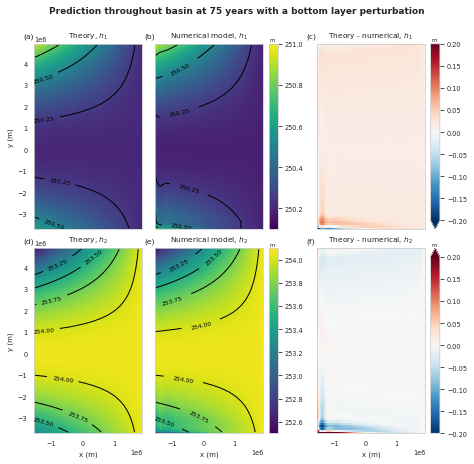

In [14]:
import seaborn as sns
sns.set_style("whitegrid")

scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)

(h1_pred_bottompert[:-ny//7,:]).plot(ax=ax7,vmax=251,vmin=250.1,edgecolor='face',add_colorbar=False)
contour_lines=h1_pred_bottompert[:-ny // 7, :].plot.contour(ax=ax7,levels=[250.25,250.5,250.75], colors='k', linewidths=1)
ax7.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax7.set_title(r'Theory, $h_1$')
ax7.set_title('(a)',loc='left',x=-0.1)

(h1_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax8,vmax=251,vmin=250.1,edgecolor='face')
contour_lines=h1_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1].plot.contour(ax=ax8,levels=[250.25,250.5,250.75], colors='k', linewidths=1)
ax8.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax8.set_title('(b)',loc='left',x=-0.1)
ax8.set_title(r'Numerical model, $h_1$')



(h1_pred_bottompert[:-ny//7]-h1_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax9,vmax=0.2,edgecolor='face')
ax9.set_title(r'Theory - numerical, $h_1$')
ax9.set_title('(c)',loc='left',x=-0.1)



(h2_pred_bottompert[:-ny//7,:]).plot(ax=ax10,vmax=254.1,vmin=252.5,edgecolor='face',add_colorbar=False)
contour_lines=h2_pred_bottompert[:-ny // 7, :].plot.contour(ax=ax10,levels=[254,253.75,253.5,253.25], colors='k', linewidths=1)
ax10.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax10.set_title(r'Theory, $h_2$')
ax10.set_title('(d)',loc='left',x=-0.1)


(h2_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax11,vmax=254.1,vmin=252.5,edgecolor='face')
contour_lines=h2_pred_bottompert[:-ny // 7, :].plot.contour(ax=ax11,levels=[254,253.75,253.5,253.25], colors='k', linewidths=1)
ax11.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax11.set_title(r'Numerical model, $h_2$')
ax11.set_title('(e)',loc='left',x=-0.1)
#ax11.set_title('m',loc='right',x=1.12)

(h2_pred_bottompert[:-ny//7]-h2_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax12,vmax=0.2,edgecolor='face')
ax12.set_title(r'Theory - numerical, $h_2$')
ax12.set_title('(f)',loc='left',x=-0.1)
#ax12.set_title('m',loc='right',x=1.12)


fig.text(0.57, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.57, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)


fig.text(0.918, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.918, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)



ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('x (m)')
ax11.set_xlabel('x (m)')
ax12.set_xlabel('x (m)')
ax7.set_ylabel('y (m)')
ax8.set_ylabel('')
ax9.set_ylabel('')
ax10.set_ylabel('y (m)')
ax11.set_ylabel('')
ax12.set_ylabel('')


ax8.set_yticks([])
ax9.set_yticks([])
ax11.set_yticks([])
ax12.set_yticks([])


ax7.set_xticks([])
ax8.set_xticks([])
ax9.set_xticks([])


fig.suptitle('Prediction throughout basin at 75 years with a bottom layer perturbation', fontsize=18*scaling,y=1.05, fontweight='bold')
import matplotlib
matplotlib.pyplot.savefig('75_year_bottom_prediction_revisions.pdf', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

## 2a. Make a prediction at every time instead of just the end time

In [15]:
#Predict at every time
pred_h1_bottompert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h2 height in the bottom perturbation experiment
for k in range(0,np.shape(h1_east_est)[0]):
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0: #if the time isn't more than the lag time off the eastern boundary, you need to use the initial condition where relevant
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
                    pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1
            else:
                pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*H1+b2_1*H1+b3_1*H1+b4_1*H1
                pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*H1+b2_2*H1+b3_2*H1+b4_2*H1

    print(k)

#convert these all to xarrays
h1_pred_bottompert_time=xr.DataArray(pred_h1_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_bottompert_time=xr.DataArray(pred_h2_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x","time"]) #convert to an xarray 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
# Save them so we don't have to run them again if we don't want to
with open('./intermediate_files_cleaned/pred_h1_bottompert_grid_time_250m_matchmitgcminput_newbdcond.npy', 'wb') as f:
    np.save(f,h1_pred_bottompert_time)
with open('./intermediate_files_cleaned/pred_h2_bottompert_grid_time_250m_matchmitgcminput_newbdcond.npy', 'wb') as f:
    np.save(f,h2_pred_bottompert_time)

# 3. Analytics to predict each layer thickness. Top layer perturbation

In [17]:
# predict eastern boundary height
c1=np.zeros(np.size(h1_xr_bottom[:,10,10])-ny//7-7-30) 
for j in range(0,np.size(h1_xr_bottom[:,10,10])-ny//7-7-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1]=1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

last_grid_pt=ny-ny//7-7


lag_l1=(((128-wbc)/128)*L_x/(((3+np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(((3-np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1

#Coefficients for the h_1 lag equation

b1_1=(5+np.sqrt(5))/10
b2_1=np.sqrt(5)/5
b3_1=(5-np.sqrt(5))/10
b4_1=-b2_1

#Coefficients for the h_2 lag equation
b1_2=1/np.sqrt(5)
b2_2=-(1-np.sqrt(5))/(2*np.sqrt(5))
b3_2=-1/np.sqrt(5)
b4_2=(1+np.sqrt(5))/(2*np.sqrt(5))


h1_east_est=H1*np.ones(4444)
h2_east_est=H1*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=H1*np.ones(np.size(c1))
    est_h2_bd=H1*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*H1+b4_1*H1
    #estimate western bdd of bottom layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*H1+b4_2*H1
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_top[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_top[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    #estimate of flux at southern boundary using only numerical information from wbc
    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_top[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_top[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])

    #estimate of flux at northern boundary using only numerical information from wbc
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

    #update h1 or h2 eastern boundary height
    h1_east_est[k]=((-dy*c1_cap*est_h1_bd).sum()-T_s1+T_s2+T_n1-T_n2)/(-c1_cap*dy).sum()
    h2_east_est[k]=((-dy*c1_cap*(est_h1_bd+est_h2_bd)).sum()-T_s2+T_n2+(h1_east_est[k]*c1_cap*dy).sum())/(-c1_cap*dy).sum()

/state/partition1/job-55926434/ipykernel_401192/1555785792.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


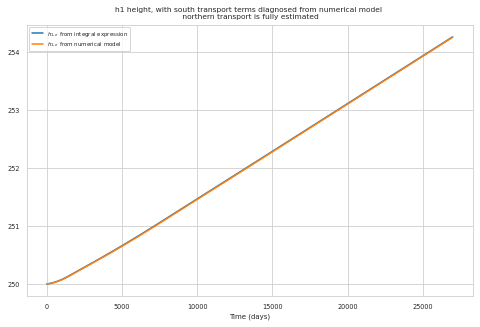

In [18]:
fig,ax=plt.subplots(figsize=(8,5))
import seaborn as sns
sns.set_style("whitegrid")
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height, with south transport terms diagnosed from numerical model \n northern transport is fully estimated')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

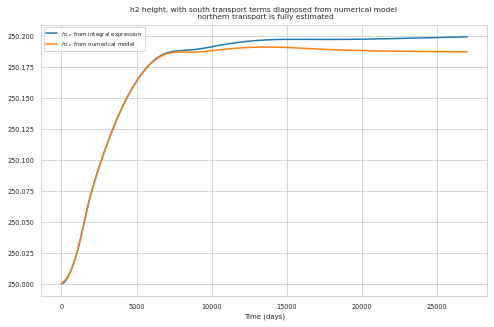

In [19]:
fig,ax=plt.subplots(figsize=(8,5))
import seaborn as sns
sns.set_style("whitegrid")
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h2_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height, with south transport terms diagnosed from numerical model \n northern transport is fully estimated')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [20]:
#Predict the height throughout the basin using lag equation at the END TIME

pred_h1_toppert_grid=np.zeros([129-30,128-wbc])
pred_h2_toppert_grid=np.zeros([129-30,128-wbc]) 
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0:
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1



#convert these all to xarrays
h1_pred_toppert=xr.DataArray(pred_h1_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_toppert=xr.DataArray(pred_h2_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

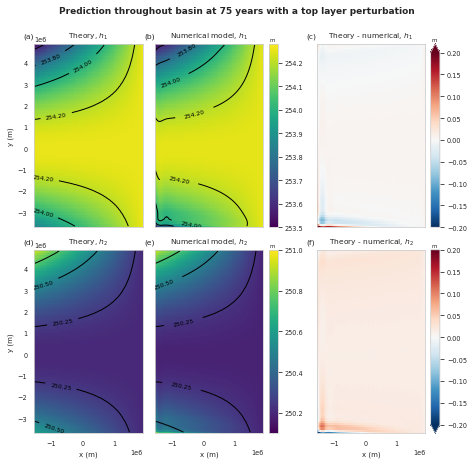

In [21]:
import seaborn as sns
sns.set_style("whitegrid")

scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)

(h1_pred_toppert[:-ny//7,:]).plot(ax=ax7,edgecolor='face',vmax=254.28,vmin=253.5,add_colorbar=False)
contour_lines=h1_pred_toppert[:-ny // 7, :].plot.contour(ax=ax7,levels=[254.2,254,253.8,253.6], colors='k', linewidths=1)
ax7.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax7.set_title(r'Theory, $h_1$')
ax7.set_title('(a)',loc='left',x=-0.1)

(h1_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax8,vmax=254.28,vmin=253.5,edgecolor='face')
contour_lines=h1_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1].plot.contour(ax=ax8,levels=[254.2,254,253.8,253.6], colors='k', linewidths=1)
ax8.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax8.set_title('(b)',loc='left',x=-0.1)
ax8.set_title(r'Numerical model, $h_1$')



(h1_pred_toppert[:-ny//7]-h1_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax9,vmax=0.2,edgecolor='face')
ax9.set_title(r'Theory - numerical, $h_1$')
ax9.set_title('(c)',loc='left',x=-0.1)



(h2_pred_toppert[:-ny//7,:]).plot(ax=ax10,vmax=251,vmin=250.1,edgecolor='face',add_colorbar=False)
contour_lines=h2_pred_toppert[:-ny // 7, :].plot.contour(ax=ax10,levels=[250.25,250.5,250.75], colors='k', linewidths=1)
ax10.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax10.set_title(r'Theory, $h_2$')
ax10.set_title('(d)',loc='left',x=-0.1)


(h2_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax11,vmax=251,vmin=250.1,edgecolor='face')
contour_lines=h2_pred_toppert[:-ny // 7, :].plot.contour(ax=ax11,levels=[250.25,250.5,250.75], colors='k', linewidths=1)
ax11.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax11.set_title(r'Numerical model, $h_2$')
ax11.set_title('(e)',loc='left',x=-0.1)
#ax11.set_title('m',loc='right',x=1.12)

(h2_pred_toppert[:-ny//7]-h2_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax12,vmax=0.2,edgecolor='face')
ax12.set_title(r'Theory - numerical, $h_2$')
ax12.set_title('(f)',loc='left',x=-0.1)
#ax12.set_title('m',loc='right',x=1.12)

fig.text(0.57, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.57, 0.4955, 'm', ha='left', va='center', fontsize=11*scaling)


fig.text(0.918, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.918, 0.4955, 'm', ha='left', va='center', fontsize=11*scaling)





ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('x (m)')
ax11.set_xlabel('x (m)')
ax12.set_xlabel('x (m)')
ax7.set_ylabel('y (m)')
ax8.set_ylabel('')
ax9.set_ylabel('')
ax10.set_ylabel('y (m)')
ax11.set_ylabel('')
ax12.set_ylabel('')


ax8.set_yticks([])
ax9.set_yticks([])
ax11.set_yticks([])
ax12.set_yticks([])


ax7.set_xticks([])
ax8.set_xticks([])
ax9.set_xticks([])


fig.suptitle('Prediction throughout basin at 75 years with a top layer perturbation', fontsize=18*scaling,y=1.05, fontweight='bold')
import matplotlib
matplotlib.pyplot.savefig('75_year_top_prediction_revisions.pdf', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

## 3a. Make a prediction at every time instead of just the end time

In [22]:
# Predict at every time 
pred_h1_toppert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h1 height in the bottom perturbation experiment
pred_h2_toppert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h2 height in the bottom perturbation experiment
for k in range(0,np.shape(h1_east_est)[0]):
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0:
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
                    pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1
            else:
                pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*H1+b2_1*H1+b3_1*H1+b4_1*H1
                pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*H1+b2_2*H1+b3_2*H1+b4_2*H1

    print(k)

#convert these all to xarrays
h1_pred_toppert_time=xr.DataArray(pred_h1_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_toppert_time=xr.DataArray(pred_h2_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x","time"]) #convert to an xarray 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
with open('./intermediate_files_cleaned/pred_h1_toppert_grid_time_250m_matchmitgcminput_newbdcond.npy', 'wb') as f:
    np.save(f,h1_pred_toppert_time)
with open('./intermediate_files_cleaned/pred_h2_toppert_grid_time_250m_matchmitgcminput_newbdcond.npy', 'wb') as f:
    np.save(f,h2_pred_toppert_time)

# 4. To make Figure 3 in paper, we need to be able to compare against MITgcm results
Load in the MITgcm results first

In [24]:
#Layer diagnostics in the control simulation. NOTE: These are available on a google drive, at:
#https://drive.google.com/drive/folders/1Z1Tk683nuRAuMG4KPhCP8TACMFuEWxJC?usp=sharing
control_timeperiod1 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6600yrs_norelax/layDiag.nc')
control_timeperiod2 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6660yrs_norelax/layDiag.nc')
control_timeperiod3 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6720yrs_norelax/layDiag.nc')
control_timeperiod4 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6780yrs_norelax/layDiag.nc')
control_laydiag=xr.concat([control_timeperiod1,control_timeperiod2,control_timeperiod3,control_timeperiod4],dim='T')

In [25]:
#Layer diagnostics in the surface simulation
surface_timeperiod1 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6600yrs_surface/layDiag.nc')
surface_timeperiod2 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6660yrs_surface/layDiag.nc')
surface_timeperiod3 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6720yrs_surface/layDiag.nc')
surface_timeperiod4 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6780yrs_surface/layDiag.nc')
surface_laydiag=xr.concat([surface_timeperiod1,surface_timeperiod2,surface_timeperiod3,surface_timeperiod4],dim='T')

In [26]:
#Layer diagnostics in the deep simulation
deep_timeperiod1 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6600yrs_deep/layDiag.nc')
deep_timeperiod2 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6660yrs_deep/layDiag.nc')
deep_timeperiod3 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6720yrs_deep/layDiag.nc')
deep_timeperiod4 = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/run_6780yrs_deep/layDiag.nc')
deep_laydiag=xr.concat([deep_timeperiod1,deep_timeperiod2,deep_timeperiod3,deep_timeperiod4],dim='T')

In [27]:
#The grid from MITgcm
grid = xr.open_dataset('/scratch/abf376/layer_diagnostics_grl/addmass_grid.nc')

In [28]:
import xesmf as xe
ds_out = xr.Dataset(
    {
        "Y": (["Y"], np.array(grid.Y), {"units": "degrees_north"}),
        "X": (["X"], np.array(grid.X), {"units": "degrees_east"}),
    }
)
regridder = xe.Regridder(deep_laydiag.LaHs1RHO, ds_out, "bilinear")

deep_thickness=regridder(deep_laydiag.LaHs1RHO,keep_attrs=True)
control_thickness=regridder(control_laydiag.LaHs1RHO,keep_attrs=True)
surface_thickness=regridder(surface_laydiag.LaHs1RHO,keep_attrs=True)


globalmean_01 = xr.open_dataset('/scratch/abf376/addmass_globalmean_01Sv.nc') #has both deep and surf in it
da=grid.dx*grid.dy
dA = da.where(globalmean_01.SALT_s[-1,0,:,:]>1)

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


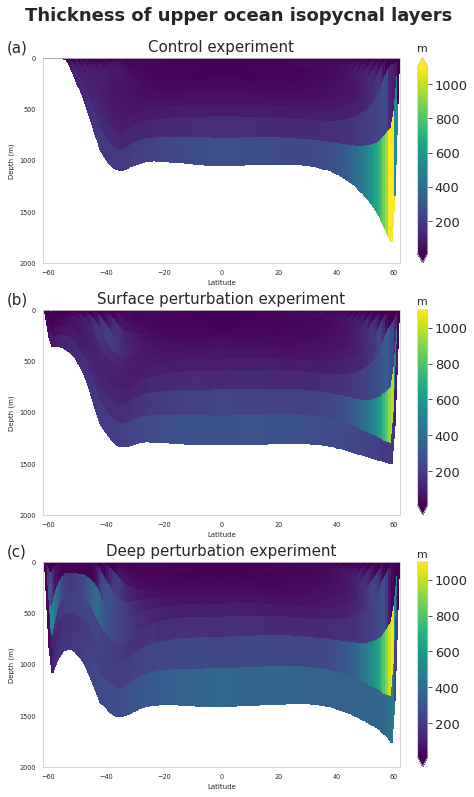

In [30]:
iso_level=25 #set the level to sum down to (this is just indexing, we have 39 tracked layers, we sum down to the 25th)

fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(6.47,10.5), constrained_layout=True)

from matplotlib import rcParams
scaling=1 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})



zrho_control=((control_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X'))).cumsum('Zd000040')
thickness_plot=((control_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X')))
thickness_plot=thickness_plot.assign_coords({"depth": zrho_control})
thickness_plot[:iso_level,:].plot(y='depth',yincrease=False,vmin=10,vmax=1100,ax=ax1,edgecolor='face')
ax1.set_ylim([2000,0])
ax1.set_title('Control experiment')
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Latitude')
ax1.set_title('(a)',loc='left',x=-0.1)
fig.text(0.882, 0.985, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.882, 0.65, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.882, 0.315, 'm', ha='left', va='center', fontsize=11*scaling)



zrho_surface=((surface_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X'))).cumsum('Zd000040')
thickness_plot=((surface_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X')))
thickness_plot=thickness_plot.assign_coords({"depth": zrho_surface})
thickness_plot[:iso_level,:].plot(y='depth',yincrease=False,vmin=10,vmax=1100,ax=ax2,edgecolor='face')
ax2.set_ylim([2000,0])
ax2.set_title('Surface perturbation experiment')
ax2.set_ylabel('Depth (m)')
ax2.set_title('(b)',loc='left',x=-0.1)
ax2.set_xlabel('Latitude')




zrho_deep=((deep_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X'))).cumsum('Zd000040')
thickness_plot=((deep_thickness[-10:,:,:,:]*grid.dx).sum('X').mean('T')/(grid.dx.sum('X')))
thickness_plot=thickness_plot.assign_coords({"depth": zrho_deep})
thickness_plot[:iso_level,:].plot(y='depth',yincrease=False,vmin=10,vmax=1100,ax=ax3,edgecolor='face')
ax3.set_ylim([2000,0])
ax3.set_title('Deep perturbation experiment')
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Latitude')
ax3.set_title('(c)',loc='left',x=-0.1)




fig.suptitle('Thickness of upper ocean isopycnal layers', fontsize=18*scaling, y=1.04, fontweight='bold')


import matplotlib
plt.savefig('isopycnal_depths_revisions.pdf',dpi=500,bbox_inches='tight')

In [31]:
#Sum down to iso_level and then average this thickness globally or in the NH. I.e., this is either the NH or global average of the above plot
thickness_deep_NH=((((deep_thickness.where(deep_thickness.Y>0))[:,:iso_level,:,:]*dA).sum('X').sum('Y'))/(dA.where(control_thickness.Y>0).sum('X').sum('Y'))).sum('Zd000040')
thickness_deep_global=((((deep_thickness)[:,:iso_level,:,:]*dA).sum('X').sum('Y'))/(dA.sum('X').sum('Y'))).sum('Zd000040')


thickness_surface_NH=((((surface_thickness.where(surface_thickness.Y>0))[:,:iso_level,:,:]*dA).sum('X').sum('Y'))/(dA.where(control_thickness.Y>0).sum('X').sum('Y'))).sum('Zd000040')
thickness_surface_global=((((surface_thickness)[:,:iso_level,:,:]*dA).sum('X').sum('Y'))/(dA.sum('X').sum('Y'))).sum('Zd000040')

In [32]:
# In case you don't want to rerun the computation of the 2.5-layer prediction in time, you can just load in
# These files aren't supplied because they're large, but they can be easily generated from above and then loaded in when you need them
h1_pred_bottompert_time=np.load('./intermediate_files_cleaned/pred_h1_bottompert_grid_time_250m_matchmitgcminput_newbdcond.npy')
h2_pred_bottompert_time=np.load('./intermediate_files_cleaned/pred_h2_bottompert_grid_time_250m_matchmitgcminput_newbdcond.npy')

h1_pred_toppert_time=np.load('./intermediate_files_cleaned/pred_h1_toppert_grid_time_250m_matchmitgcminput_newbdcond.npy')
h2_pred_toppert_time=np.load('./intermediate_files_cleaned/pred_h2_toppert_grid_time_250m_matchmitgcminput_newbdcond.npy')

wbc=12
h1_pred_toppert_time=xr.DataArray(h1_pred_toppert_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_toppert_time=xr.DataArray(h2_pred_toppert_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x","time"]) #convert to an xarray 


h1_pred_bottompert_time=xr.DataArray(h1_pred_bottompert_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_bottompert_time=xr.DataArray(h2_pred_bottompert_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x","time"]) #convert to an xarray 

<xarray.DataArray 'time' ()>
array(41.26881591)
Coordinates:
    time      float64 1.486e+04
    variable  <U29 '__xarray_dataarray_variable__'


Text(0.5, 1.07, 'Change in Northern Hemisphere anomaly \n of upper ocean thickness')

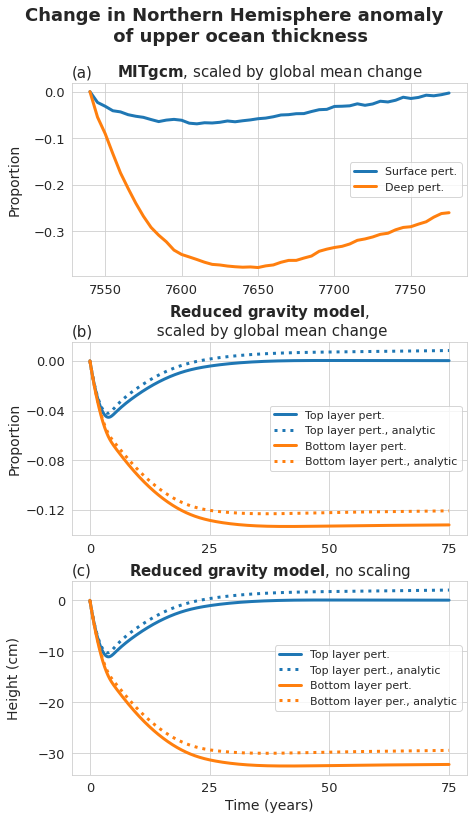

In [33]:
# Make fig 3
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(6.47,10.5), constrained_layout=True)

scaling=1 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})


#MITGCM
index_mitgcm=(thickness_deep_NH-thickness_deep_global).argmin()
scale_factor_mitgcm=(thickness_deep_global[int(index_mitgcm)]-thickness_deep_global[0])



ax1.plot(surface_laydiag.T/(24*60*60*360)+995,(thickness_surface_NH-thickness_surface_global-(thickness_surface_NH-thickness_surface_global)[0])/scale_factor_mitgcm,linewidth=3)
ax1.plot(surface_laydiag.T/(24*60*60*360)+995,(thickness_deep_NH-thickness_deep_global-(thickness_deep_NH-thickness_deep_global)[0])/scale_factor_mitgcm,linewidth=3)
#ax1.set_title('Upper ocean thickness, MITgcm \n Change in NH anomaly \n Scaled by global mean change')
ax1.set_title(r'$\bf{MITgcm}$, scaled by global mean change')
#ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Proportion')
ax1.legend(['Surface pert.','Deep pert.'])
ax1.set_title('(a)',loc='left')
ax1.set_yticks(np.linspace(0,-0.3,4))  # make only have 5 labels


#### RG scaled
#Scale by the timescales of the system 


last=ny-ny//7

sum_top=(h1_xr_top+h2_xr_top)
sum_top_analytic=(h1_pred_toppert_time+h2_pred_toppert_time)


sum_bottom=(h1_xr_bottom+h2_xr_bottom)
sum_bottom_analytic=(h1_pred_bottompert_time+h2_pred_bottompert_time)

index=((100*(sum_bottom[30:int(last),:,:].where(sum_bottom.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y')))).argmin()
print(sum_bottom.time[index]/360)
scale_factor=(sum_bottom.mean('x').mean('y')[index]-sum_bottom.mean('x').mean('y')[0])


ax2.plot(sum_bottom.time/360,(100*(sum_top[30:int(last),:,:].where(sum_top.y>0).mean('x').mean('y')-sum_top.mean('x').mean('y')))/(100*scale_factor),label='Top layer pert.',linewidth=3)
ax2.plot(sum_top.time/360,(100*(sum_top_analytic[:-ny//7+1,:,:].where(sum_top_analytic.y>0).mean('x').mean('y')-sum_top.mean('x').mean('y')))/(100*scale_factor),color='tab:blue',linestyle='dotted',label='Top layer pert., analytic',linewidth=3)
ax2.plot(sum_bottom.time/360,(100*(sum_bottom[30:int(last),:,:].where(sum_bottom.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y')))/(100*scale_factor),label='Bottom layer pert.',linewidth=3)
ax2.plot(sum_bottom.time/360,(100*(sum_bottom_analytic[:-ny//7+1,:,:].where(sum_bottom_analytic.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y')))/(100*scale_factor),color='tab:orange',linestyle='dotted',label='Bottom layer pert., analytic',linewidth=3)
ax2.set_xticks(np.arange(0, 76, 25))  # Show x-ticks every 25 years
ax2.set_xticklabels([f"{int(year)}" for year in np.arange(0, 76, 25)])
ax2.set_ylabel('Proportion')
#ax2.set_xlabel('Time (years)')
ax2.legend()
#ax2.set_title('Upper ocean thickness, 2.5-layer model \n Change in NH anomaly \n Scaled by global mean change')
ax2.set_title(r'$\bf{Reduced\ gravity\ model}$,'+ '\n scaled by global mean change')
ax2.set_title('(b)',loc='left')
ax2.set_yticks(np.linspace(0,-0.12,4))  # make only have 4 labels
#### RG no scale 
#Scale by the timescales of the system 


ax3.plot(sum_bottom.time/360,(100*(sum_top[30:int(last),:,:].where(sum_top.y>0).mean('x').mean('y')-sum_top.mean('x').mean('y'))),label='Top layer pert.',linewidth=3)
ax3.plot(sum_top.time/360,(100*(sum_top_analytic[:-ny//7+1,:,:].where(sum_top_analytic.y>0).mean('x').mean('y')-sum_top.mean('x').mean('y'))),color='tab:blue',linestyle='dotted',label='Top layer pert., analytic',linewidth=3)
ax3.plot(sum_bottom.time/360,(100*(sum_bottom[30:int(last),:,:].where(sum_bottom.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y'))),label='Bottom layer pert.',linewidth=3)
ax3.plot(sum_bottom.time/360,(100*(sum_bottom_analytic[:-ny//7+1,:,:].where(sum_bottom_analytic.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y'))),color='tab:orange',linestyle='dotted',label='Bottom layer per., analytic',linewidth=3)
ax3.set_xticks(np.arange(0, 76, 25))  # Show x-ticks every 25 years
ax3.set_xticklabels([f"{int(year)}" for year in np.arange(0, 76, 25)])
ax3.set_ylabel('Height (cm)')
ax3.set_xlabel('Time (years)')
ax3.legend()
#ax3.set_title('Upper ocean thickness, 2.5-layer model \n Change in NH anomaly')
ax3.set_title(r'$\bf{Reduced\ gravity\ model}$, no scaling')
ax3.set_title('(c)',loc='left')
ax3.set_yticks(np.linspace(0,-30,4))  # make only have 4 labels


fig.align_ylabels()
fig.suptitle('Change in Northern Hemisphere anomaly \n of upper ocean thickness', fontsize=18*scaling, y=1.07, fontweight='bold')
#import matplotlib
#matplotlib.pyplot.savefig('fig3_upperoceanthickness_grl_updaterevisions.pdf', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

# 5. More appendix figures

[Text(0, 0, '0'), Text(25, 0, '25'), Text(50, 0, '50'), Text(75, 0, '75')]

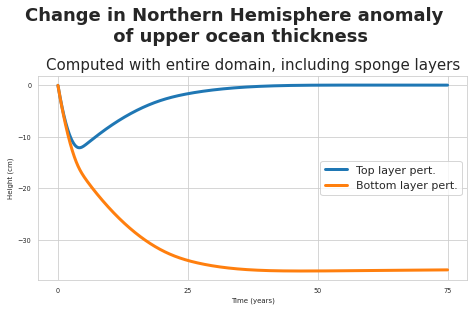

In [48]:
#Plot including the whole domain 

fig,(ax)=plt.subplots(nrows=1,ncols=1,figsize=(6.47,10.5/3), constrained_layout=True)

scaling=1 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})


sum_top=(h1_xr_top+h2_xr_top) 



sum_bottom=(h1_xr_bottom+h2_xr_bottom)
fig.suptitle('Change in Northern Hemisphere anomaly \n of upper ocean thickness', fontsize=18*scaling, y=1.19, fontweight='bold')


ax.plot(sum_bottom.time/360,100*(sum_top.where(sum_top.y>0).mean('x').mean('y')-sum_top.mean('x').mean('y')),linewidth=3,label='Top layer pert.')
ax.plot(sum_bottom.time/360,100*(sum_bottom.where(sum_bottom.y>0).mean('x').mean('y')-sum_bottom.mean('x').mean('y')),linewidth=3,label='Bottom layer pert.')

ax.set_ylabel('Height (cm)')
ax.set_xlabel('Time (years)')
ax.legend()
ax.set_title('Computed with entire domain, including sponge layers')
ax.set_xticks(np.arange(0, 76, 25))  # Show x-ticks every 25 years
ax.set_xticklabels([f"{int(year)}" for year in np.arange(0, 76, 25)])

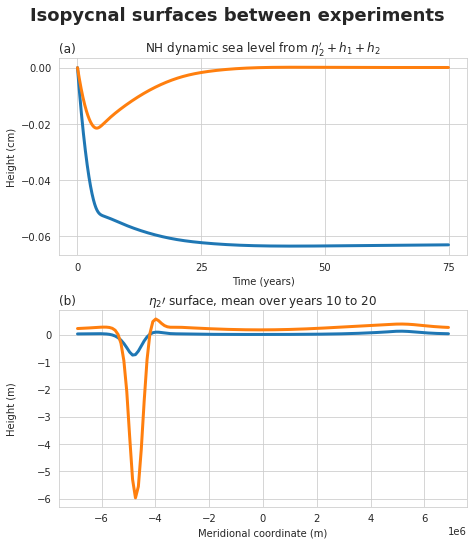

In [15]:
#Dynamic sea level and the location of the eta_2 isopycnal
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(6.47,2*10.5/3), constrained_layout=True)

##### define the actual sea level
eta2_variability_bottom=((-rho1*(h1_xr_bottom)-rho2*(h2_xr_bottom)))/rho3-(((-rho1*(h1_xr_bottom)-rho2*(h2_xr_bottom)))/rho3).mean('x').mean('y')
total_sealevel_bottom=eta2_variability_bottom+h1_xr_bottom+h2_xr_bottom-500
nh_sealevel_bottom=total_sealevel_bottom[30:int(last),:,:].where(total_sealevel_bottom.y>0).mean('x').mean('y')-total_sealevel_bottom.mean('x').mean('y')


eta2_variability_top=((-rho1*(h1_xr_top)-rho2*(h2_xr_top)))/rho3-(((-rho1*(h1_xr_top)-rho2*(h2_xr_top)))/rho3).mean('x').mean('y')
total_sealevel_top=eta2_variability_top+h1_xr_top+h2_xr_top-500
nh_sealevel_top=total_sealevel_top[30:int(last),:,:].where(total_sealevel_bottom.y>0).mean('x').mean('y')-total_sealevel_top.mean('x').mean('y')
################

ax.plot(h1_xr_top.time/360,100*(nh_sealevel_top),linewidth=3,color='tab:blue')
ax.plot(h1_xr_top.time/360,100*(nh_sealevel_bottom),linewidth=3,color='tab:orange')
ax.set_ylabel('Height (cm)')
ax.set_xlabel('Time (years)')
ax.set_title(r'NH dynamic sea level from $\eta_2^\prime+h_1+h_2$')
ax.set_title('(a)',loc='left')
ax.set_xticks(np.arange(0, 76, 25))  # Show x-ticks every 25 years
ax.set_xticklabels([f"{int(year)}" for year in np.arange(0, 76, 25)])
ax.set_yticks(np.linspace(0,-0.06,4))  # make only have 4 labels



ax2.plot(eta2_variability_top.y,(eta2_variability_top[:,:,592*1:2*592].mean('time').mean('x')),linewidth=3,color='tab:blue')
ax2.plot(eta2_variability_top.y,(eta2_variability_bottom[:,:,592*1:2*592].mean('time').mean('x')),linewidth=3,color='tab:orange')
ax2.set_ylabel('Height (m)')
ax2.set_xlabel('Meridional coordinate (m)')
ax2.set_title(r'$\eta_2 \prime$ surface, mean over years 10 to 20')
ax2.set_title('(b)',loc='left')

fig.suptitle('Isopycnal surfaces between experiments', fontsize=18*scaling, y=1.06, fontweight='bold')
fig.align_ylabels()


import matplotlib
plt.savefig('isopycnal_locations_appendix.pdf',dpi=500,bbox_inches='tight')